In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40

import matplotlib.pyplot as plt
import numpy as np

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera
from sionna.rt.utils import r_hat
from sionna.ofdm import ResourceGrid
from sionna.channel.utils import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.constants import SPEED_OF_LIGHT

In [2]:
import trimesh
scene = load_scene("../models/simple_wedge/simple_wedge.xml")
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [3]:
scene = load_scene("../models/untitled/untitled.xml")

# Configure arrays for all transmitters and receivers in the scene
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso","V")
scene.rx_array = scene.tx_array

# Add a transmitter and a receiver
scene.add(Transmitter("tx", [-25,0.1,50]))
scene.add(Receiver("rx",    [ 25,0.1,50]))

# Compute paths
paths = scene.compute_paths(max_depth=1)
paths.normalize_delays = False # Do not normalize the delays such that the first path arrives at tau=0

scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [4]:
scene = load_scene("../models/wireless insite/insite.xml")

# Configure arrays for all transmitters and receivers in the scene
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso","V")
scene.rx_array = scene.tx_array

# Add a transmitter and a receiver
scene.add(Transmitter("tx", [ 1, 1, 1]))
scene.add(Receiver("rx",    [ 7, 4, 1]))

# Compute paths
# paths = scene.compute_paths(max_depth=1)
# paths.normalize_delays = False # Do not normalize the delays such that the first path arrives at tau=0
scene.preview()



Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [5]:
my_cam = Camera("my_cam", position=[8, 8, 30], look_at=[0, 0, -1])
scene.add(my_cam)

In [6]:
scene.frequency = 3e9
scene.synthetic_array = True
paths = scene.compute_paths(max_depth=4, 
                            num_samples=1e6)
scene.preview(paths, show_devices=True, show_paths=True)

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [7]:
# tau表示每个信道的时延
print(paths.tau.numpy().squeeze())
# print(paths.a.numpy().squeeze())
# a表示信道系数，a的幅值的平方表示接收信号的能量
print(np.abs(paths.a.numpy().squeeze())**2)
# 用分贝形式表示
print(10 * np.log10(np.abs(paths.a.numpy().squeeze())**2))
# 每个物体经过的路径
# 0 - 木头门 | 1 - 玻璃窗 | 2 - 金属 | 3 - 墙面
print(paths.objects.numpy().squeeze())

[5.05094633e-10 2.95263369e-09 5.92128302e-09 4.14281054e-09
 1.28844135e-08 2.25159660e-08 7.00309144e-09 2.08834940e-08
 2.60581601e-08 5.57271029e-08 4.91110974e-08 4.60267913e-09
 5.50441470e-09 0.00000000e+00 2.96927780e-08 2.91678290e-08
 5.87105369e-08 5.71860959e-08 5.13542666e-08 4.19252579e-08
 6.36108837e-08 3.01597147e-08 5.58373223e-08]
[3.07817032e-07 1.50882585e-07 5.27110480e-08 1.62491077e-07
 8.37121661e-09 1.06159019e-08 5.81705422e-08 2.34364728e-09
 1.73037540e-09 2.65512501e-09 1.99755927e-08 1.88711567e-07
 1.45615360e-07 1.07784490e-06 1.45045642e-10 3.51489549e-09
 3.37157219e-10 3.54305141e-10 1.05087834e-10 3.61768393e-10
 4.11295387e-10 1.68628789e-09 1.23574750e-09]
[-65.11708  -68.213615 -72.78098  -67.89171  -80.772125 -79.74044
 -72.352974 -86.30108  -87.6186   -85.759155 -76.995    -67.24202
 -68.367935 -59.67444  -98.384964 -84.54088  -94.72168  -94.506226
 -99.78448  -94.415695 -93.85846  -87.73068  -89.0807  ]
[[ 3  3  3  1  3  1  3  3  0  3  2  3  3

[3 3 3 1 3 1 3 3 0 3 2 3 3 2 3 3 3 3 0 0 3 3 3]
[-65.11708  -68.213615 -72.78098  -67.89171  -80.772125 -79.74044
 -72.352974 -86.30108  -87.6186   -85.759155 -76.995    -67.24202
 -68.367935 -59.67444  -98.384964 -84.54088  -94.72168  -94.506226
 -99.78448  -94.415695 -93.85846  -87.73068  -89.0807  ]
{0: array([87.6186  , 94.415695, 99.78448 ], dtype=float32), 1: array([67.89171, 79.74044], dtype=float32), 2: array([59.67444, 76.995  ], dtype=float32), 3: array([65.11708 , 67.24202 , 68.213615, 68.367935, 72.352974, 72.78098 ,
       80.772125, 84.54088 , 85.759155, 86.30108 , 87.73068 , 89.0807  ,
       93.85846 , 94.506226, 94.72168 , 98.384964], dtype=float32)}
[0 1 2 3]


<Figure size 640x480 with 0 Axes>

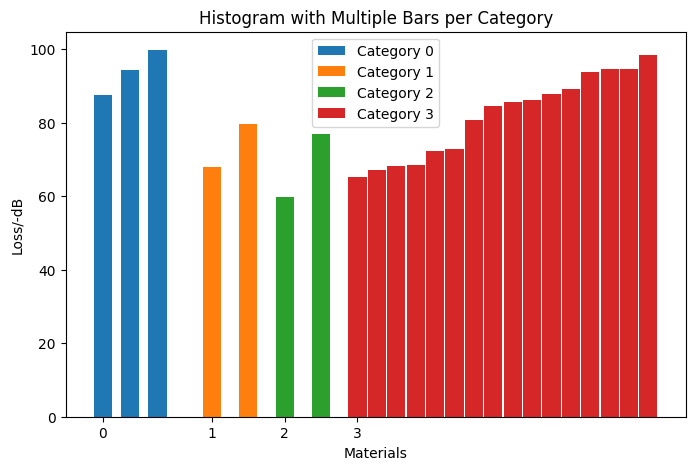

In [8]:
# and plot results
plt.figure()

# 输入数据
categories = paths.objects.numpy().squeeze()[0]
values = 10 * np.log10(np.abs(paths.a.numpy().squeeze())**2)
print(categories)
print(values)

# 找到唯一类别
unique_categories = np.unique(categories)

# 为每个类别分组数据
grouped_values = {cat: np.sort(-values[categories == cat]) for cat in unique_categories}
print(grouped_values)

# 计算柱状图的位置
bar_width = 0.2  # 每个柱子的宽度
x_positions = np.arange(len(unique_categories))  # 每个类别的 x 位置
print(x_positions)
spacing = 0.3  # 类别之间的间隔，增大此值可以使柱子之间有更多间隔

# 颜色列表（可选）
colors = ['r', 'g', 'b']

# 创建绘图
plt.figure(figsize=(8, 5))

lengths = np.insert([len(arr) for arr in grouped_values.values()], 0, 0)
spf = np.cumsum(lengths)

# 遍历类别，绘制柱状图
for i, (cat, vals) in enumerate(grouped_values.items()):
    # 为每个类别绘制多个柱子，确保它们在不同的 x 位置
    # np.linspace() 控制每个柱子在 x 轴上的具体位置，保证它们分开显示
    plt.bar(np.linspace(0, bar_width * vals.size, len(vals)) + spf[i] * bar_width * 2, 
            vals, width = bar_width, label = f'Category {cat}')

# 调整坐标轴
plt.xticks(spf[:len(grouped_values.values())] * bar_width * 2, [str(cat) for cat in unique_categories])  
plt.legend()
plt.xlabel("Materials")
plt.ylabel("Loss/-dB")
plt.title("Histogram with Multiple Bars per Category")

plt.show()

In [9]:
# Select an example object from the scene
sos = [scene.get("alldoor"), scene.get("allglass"), scene.get("allmeta"), scene.get("allwall")]

# Print name of assigned radio material for different frequenies
for so in sos:
    for f in [3e9]: # Print for differrent frequencies
        scene.frequency = f
        print(f"\nRadioMaterial: {so.radio_material.name} @ {scene.frequency/1e9:.2f}GHz")
        print("Conductivity:", so.radio_material.conductivity.numpy())
        print("Relative permittivity:", so.radio_material.relative_permittivity.numpy())
        print("Complex relative permittivity:", so.radio_material.complex_relative_permittivity.numpy())



RadioMaterial: itu_wood @ 3.00GHz
Conductivity: 0.015257255
Relative permittivity: 1.99
Complex relative permittivity: (1.99-0.09141691j)

RadioMaterial: itu_glass @ 3.00GHz
Conductivity: 0.015680457
Relative permittivity: 6.31
Complex relative permittivity: (6.31-0.0939526j)

RadioMaterial: itu_metal @ 3.00GHz
Conductivity: 10000000.0
Relative permittivity: 1.0
Complex relative permittivity: (1-59917010j)

RadioMaterial: itu_concrete @ 3.00GHz
Conductivity: 0.10910539
Relative permittivity: 5.24
Complex relative permittivity: (5.24-0.6537269j)


In [10]:
1.1
# 

1.1